# <font color = 'coral'>**Finetuning with DistilBERT base model**
- I will be following a standard model training plan using the huggingface library and WANDB to track my experiment.
  - The idea is to use the base RoBERTa model to compare how well a pre-trained model does in comparison to the last models I have trained (RNN and RoBERTa)
  - There are some class imbalances so I want to make sure I account for that within my model.

**Training Plan**
- Set the Environment
- Load the dataset
- maniupulate the splits of the dataset
- Load the pretrained distilbert tokenizer.
- Train the model
  - Download the model
  - Download and modify the model's config file.
  - Compute the metric function (ensuring we account for multilabel)(BCE)
  - Training Args
  - Instantiate the trainer
  - Setup WANDB
  - Training and Validation
- Model inference/ attach predictions to the Kaggle leaderboard
and assess performance.



# <font color = 'coral'>**Setting up the environment**

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
        # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'
        # Installing the latest torchinfo library
    !pip install torchtext -qq
    !pip install transformers evaluate wandb datasets accelerate  -U -qq

    sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00


<font color = 'coral'>***Loading Libraries***

In [ ]:
# Standard Datascience libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from pathlib import Path
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import joblib

# Huggingface, wandb, torch etc
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoConfig, pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast
import torch


In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')



In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('HF login not unsuccessful - Missing token')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Login Successful


In [ ]:
if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
# Designating paths for saving and loading
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/distilBERT-uncased'


# <font color = 'coral'>**Loading the datasets**




In [ ]:
# loading data
train_valid_df = pd.read_csv(data_folder/'train.csv')

In [ ]:
train_valid_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

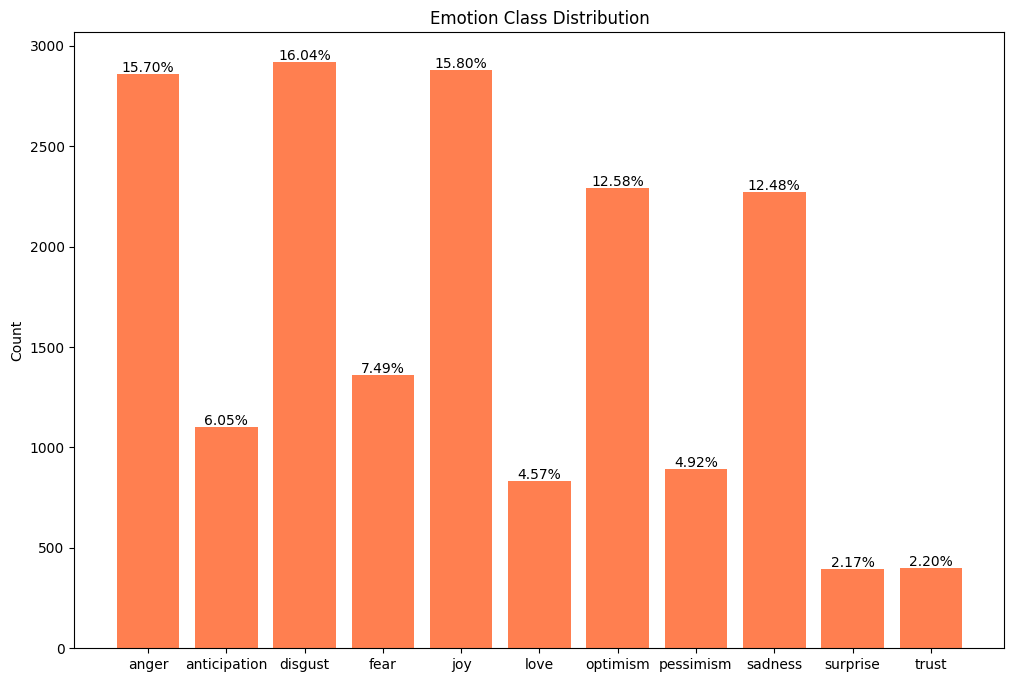

In [ ]:
# plotting of class distribution
label_counts = train_val_labels.sum()

# Total label counts
total_counts = label_counts.sum()

# percentage calculations
percentages = (label_counts/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'coral')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()

## <font color = 'coral'>**Manipulating Splits**
- For this model I plan on doing a different type of split since the RoBERTa base model did not perform so well with my last splits.

- This is likely because I did not handle the class imbalance within each split.

- Instead I will be using MultilabelStratifiedKFold from the iterstrat library.

In [ ]:
pip install iterative-stratification


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
# Instantiate the splitter
mlskf = MultilabelStratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Designate features and labels
X = train_valid_df['Tweet'].values
y = train_valid_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
        'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

# Make the splits
for train_index, val_index in mlskf.split(X,y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

In [ ]:
# Reformatting to a dataframe
train_df = train_valid_df.iloc[train_index]
val_df = train_valid_df.iloc[val_index]

In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
val_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
5,2017-22190,No but that's so cute. Atsu was probably shy a...,0,0,0,0,1,0,0,0,0,0,0
8,2017-41344,it's pretty depressing when u hit pan on ur fa...,0,0,1,0,0,0,0,0,1,0,0
22,2017-40483,Awareness of time is awareness of time lost. #...,0,0,0,0,1,1,1,0,0,0,0
32,2017-20316,@RogueCoder250 We are in so much trouble!! I d...,0,0,0,1,1,0,0,0,1,0,0
36,2017-30296,#smile every morning to a positive head start ...,0,0,0,0,1,0,1,0,0,0,0


## <font color = 'coral'>**Checking the class distribution for each set**

In [ ]:
train_labels = train_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

In [ ]:
train_labels.sum()

,0
anger,2287
anticipation,882
disgust,2336
fear,1091
joy,2301
love,665
optimism,1833
pessimism,716
sadness,1819
surprise,316


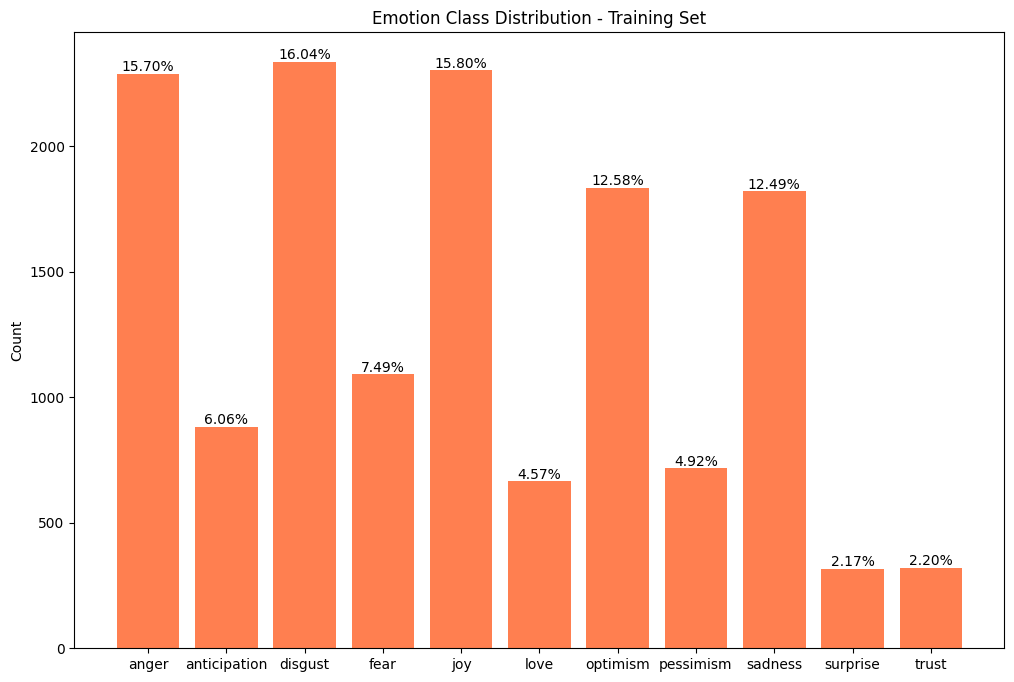

In [ ]:
# plotting of class distribution - Training Set
label_counts_t = train_labels.sum()

# Total label counts
total_counts = label_counts_t.sum()

# percentage calculations
percentages = (label_counts_t/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'coral')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()

In [ ]:
val_labels = val_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

In [ ]:
val_labels.sum()

,0
anger,572
anticipation,220
disgust,585
fear,272
joy,576
love,167
optimism,458
pessimism,179
sadness,454
surprise,80


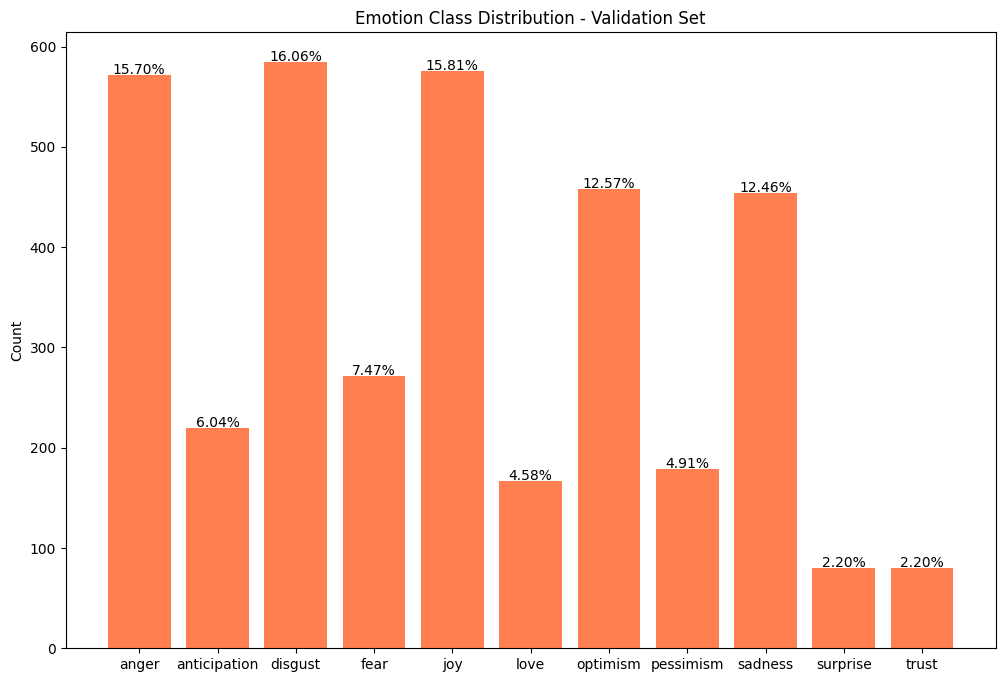

In [ ]:
# plotting of class distribution - Validation Set
label_counts_v = val_labels.sum()

# Total label counts
total_counts = label_counts_v.sum()

# percentage calculations
percentages = (label_counts_v/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'Coral')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages)):
  plt.text(i, count + 1 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

<font color = 'coral'>**Now we can clearly see that the splits accurately represent the class distributions**




In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
# Changing the features to lists
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
type(X_train)

list

In [ ]:
# Storage folders for my new splits
train_cleaned = data_folder/'train_imb_accounted_for.pkl'
valid_cleaned = data_folder/'valid_imb_accounted_for.pkl'

In [ ]:
joblib.dump((X_train, y_train), train_cleaned)
joblib.dump((X_val, y_val), valid_cleaned)

['/content/drive/MyDrive/Colab Notebooks/datasets/emotion_detection_ds/valid_imb_accounted_for.pkl']

In [ ]:
X_train, y_train = joblib.load(train_cleaned)
X_val, y_val = joblib.load(valid_cleaned)

In [ ]:
X_train[0]

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

In [ ]:
y_train[0]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
X_val[0]

"No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu"

## <font color = 'coral'>**Getting the class weights**

In [ ]:
# Calculating class weights and storing for later use in the BCELoss
class_counts = np.sum(y_train, axis = 0)

total_samples = y_train.shape[0]

# Inverse Frequency Calculation
class_weights = total_samples/(len(class_counts)*class_counts)

# Normalizing
class_weights = class_weights/np.sum(class_weights)

# Converting to tensor fo later use in loss function
class_weights = torch.tensor(class_weights, dtype = torch.float32)

print(class_counts)
print(total_samples)
print(class_weights)

[2287  882 2336 1091 2301  665 1833  716 1819  316  320]
6180
tensor([0.0321, 0.0831, 0.0314, 0.0672, 0.0319, 0.1103, 0.0400, 0.1024, 0.0403,
        0.2321, 0.2292])


## <font color = 'coral'>**Final Datset creation**

In [ ]:
trainset = Dataset.from_dict(
    {'text':X_train,
     'label':y_train}
)
validset = Dataset.from_dict(
    {'text':X_val,
     'label':y_val}
)

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 6180
})

In [ ]:
validset

Dataset({
    features: ['text', 'label'],
    num_rows: 1544
})

In [ ]:
# Compiling the trainset and validset into my training dictionary
train_val = DatasetDict({'train': trainset, 'valid':validset})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6180
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1544
    })
})

In [ ]:
train_val['train']['label'][0]

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]

## <font color='coral'>**Loading the DistilBERT tokenizer**

### The difference between DistilBERT and BERT:
- **BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model designed around two key tasks:
  - **Masked Language Modeling**: During training, 15% of the tokens in the input are randomly masked, and the model learns the masked token embeddings to better predict them.
  - **Next Sentence Prediction**: BERT is trained to predict whether one sentence follows another in a given pair (e.g., "Is sentence A followed by sentence B?").
  - While BERT can perform many classification tasks, these are the primary two.
  
- **DistilBERT** (Distilled BERT):
  - DistilBERT is a smaller and faster version of BERT, trained by applying knowledge distillation. This process involves compressing the larger BERT model into a more efficient one while retaining most of its language understanding.
  - It eliminates the next sentence prediction task, much like RoBERTa, and focuses on improving efficiency while keeping the core masked language modeling intact.
  - DistilBERT significantly reduces the size of the model and training time, making it an excellent choice for applications requiring faster inference.

- A key difference between DistilBERT and BERT is that DistilBERT is trained to offer increased speed and smaller model size.

Info on DistilBERT: [DistilBERT Tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html)


In [ ]:
# loading the tokenizer
checkpoint = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### <font color = 'coral'>**Creating the Tokenize Function**

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], truncation = True)


In [ ]:
tokenized_ds = train_val.map(tokenize, batched = True)
tokenized_ds = tokenized_ds.remove_columns(
    ['text']
)

tokenized_ds.set_format(type = 'torch') # setting the format of the dataset to PyTorch tensors

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1544 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6180
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1544
    })
})

#### <font color='Coral'>**Remapping labels to float**

- In the code below, I call a `map` function that creates a new column `float_label` by converting each label from an integer to a PyTorch float tensor. Afterward, it removes the original `Labels` column (which was of type int) and renames the new `float_label` column back to `Labels`, ensuring that the labels are now in the correct format for training.

In [ ]:
tokenized_ds = (tokenized_ds.map(lambda x: {'float_label': x['label'].to(torch.float)}, remove_columns=['label'])
                .rename_column('float_label', 'label'))

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1544 [00:00<?, ? examples/s]

In [ ]:
# Showing the changed labels
tokenized_ds['train']['label'][0:5]

tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
tokenized_ds['valid']['label'][0:5]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

# <font color = 'coral'>**Training the Model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type = 'multi_label_classification')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
class_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)

# Setting up id2label and label2id
id2label = {id_:label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id

model.config = config

In [ ]:
model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.0",
  "vocab_size": 30522
}

## <font color = 'coral'>**Creating the compute_metrics function**

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1', 'multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels = eval_pred # pulls out the labels and logits
  logits_tensor = torch.tensor(logits) # Converting the logits to a tensor
  preds = (torch.sigmoid(logits_tensor)> 0.4 ).int().numpy() # if the value is above the 0.4 threshold we predict the class as being present
  # flattens the predictions and labels into 1D format so that the calculation can be made
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # Calculating the predictions vs the references accross entire labels (all predicted labels need to match the reference labels for a doc)
  accuracy_all = accuracy.compute(predictions = preds,references = labels)
  f1_macro = f1.compute(predictions = preds, references = labels, average = 'macro')
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')

  return {
      'f1_macro':f1_macro['f1'],
      'f1_micro': f1_micro['f1'],
      'accuracy_label':accuracy_label['accuracy'],
      'accuracy_all':accuracy_all['accuracy']}

In [ ]:
run_name= 'distilbert_emotion_exp4'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=3,  # training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Increase learning rate for more aggressive updates
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps for more stable evaluations
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",  # Continue using F1 Macro as the key metric
    greater_is_better=True,  # A model is 'better' if its F1 Macro score is higher

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases
)

## <font color='coral'>**Overriding the Hugging Face Trainer**

- To ensure the Hugging Face Trainer calculates the loss using my custom class weights, I’m implementing a custom trainer that inherits the necessary arguments from the original Trainer.

- First, we extract the labels from the inputs.
- Next, we pass the inputs through the model to get the outputs.
- From the outputs, we pull out the `logits` (the raw predictions).
- We then create a `weights` variable that transfers the class weights to the GPU.
- `unsqueeze` adds a new dimension to the class weights, changing their shape to `[1, num_classes]`, and then `expand_as(logits)` expands these weights across the entire batch.
  - For instance, since my batch size is 16 samples, and I have 11 classes, the weights will be expanded to `[16, 11]`.
  - Each row in this tensor will have the same class weights, ensuring the same weights are applied to each sample in the batch.
  
- The `BCEWithLogitsLoss` function applies a sigmoid activation internally and calculates the loss for each class.
- Finally, I call `labels.float()` to ensure the labels are in the correct float format for proper loss calculation.

In [ ]:
# Custom trainer class to implement my class weights

class WeightTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Get the labels from inputs
        labels = inputs.pop('labels')

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')

        # Ensure the class_weights tensor is on the same device as the model
        loss_fn = nn.BCEWithLogitsLoss(weight=class_weights.to(model.device))

        # Calculate the loss
        loss = loss_fn(logits, labels.float())

        # Return the loss and outputs if needed
        return (loss, outputs) if return_outputs else loss

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-124-dfcff32096f4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
%env WANDB_PROJECT = multilabel_distilBERT

env: WANDB_PROJECT=multilabel_distilBERT


In [ ]:
# start training
trainer.train(resume_from_checkpoint=None)

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
50,0.279200,0.385286,0.393312,0.600292,0.838554,0.183290
100,0.287000,0.391946,0.390839,0.596951,0.835021,0.184585
150,0.301600,0.371050,0.404769,0.604795,0.841792,0.185233
200,0.311900,0.417003,0.378008,0.576535,0.827014,0.171632
250,0.299500,0.372389,0.401296,0.614327,0.841498,0.194301
300,0.311900,0.400284,0.405985,0.596396,0.824600,0.137306
350,0.310900,0.362847,0.417752,0.617216,0.844736,0.196891
400,0.293400,0.361661,0.414243,0.617521,0.842675,0.194301
450,0.276600,0.359481,0.415176,0.615854,0.844206,0.185233
500,0.282200,0.378972,0.396529,0.602740,0.839496,0.191062


TrainOutput(global_step=1161, training_loss=0.27863996815414493, metrics={'train_runtime': 144.7415, 'train_samples_per_second': 128.09, 'train_steps_per_second': 8.021, 'total_flos': 214144112282184.0, 'train_loss': 0.27863996815414493, 'epoch': 3.0})

## <font color = 'coral'>**Continuing Training from Best Checkpoint**

- Based on the results of the training process above I want to continue training based on my best checkpoint.
- To do this I will redesignate the training arguments and add epochs to the training process.
- I also want to change how often the model is evaluated.

In [ ]:
# New training params - extension of the last but with more changes
run_name= 'distilbert_emotion_exp5'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=5e-5,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),
    eval_strategy='steps',
    eval_steps=100, # increasing the rate of evaluation
    save_strategy="steps",
    save_steps=100, # increasing the rate of saving
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=100,  # increasing the logging steps
    report_to='wandb',
    run_name=run_name,
)

<font color = 'coral'>***Designating checkpoint***

In [ ]:
best_checkpoint_1 = model_folder/'checkpoint-1150'

In [ ]:
%env WANDB_PROJECT = multilabel_distilBERT

env: WANDB_PROJECT=multilabel_distilBERT


In [ ]:
trainer.train(resume_from_checkpoint = best_checkpoint_1)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
1200,0.257800,0.367578,0.445998,0.632857,0.850389,0.211788
1250,0.257600,0.372305,0.468666,0.627823,0.842793,0.188472
1300,0.246100,0.366478,0.475942,0.637093,0.848269,0.207254
1350,0.253600,0.364769,0.481924,0.636040,0.849329,0.208549
1400,0.246200,0.365205,0.475748,0.636167,0.851095,0.212435
1450,0.258400,0.366937,0.473696,0.636208,0.849976,0.217617
1500,0.244700,0.367770,0.478559,0.642918,0.852449,0.213083
1550,0.238300,0.367188,0.479160,0.639294,0.853097,0.216969
1600,0.233700,0.369549,0.472864,0.639619,0.853038,0.218264
1650,0.231600,0.367032,0.479179,0.642754,0.854569,0.222798


TrainOutput(global_step=1935, training_loss=0.09831294422001802, metrics={'train_runtime': 102.1305, 'train_samples_per_second': 302.554, 'train_steps_per_second': 18.946, 'total_flos': 356282708007072.0, 'train_loss': 0.09831294422001802, 'epoch': 5.0})

## <font color = 'coral'>***Continuing Training***

- Based on the model continuing to improve I am going to keep training from the next checkpoint.
- To better compensate for more fine-grained patterns I am going to implement a learning-rate scheduler.


<font color='coral'>***Leaving this code here for future loading of model weights***</font>

```python
# Load model weights only, without additional metadata
model.load_state_dict(torch.load("path_to_checkpoint", weights_only=True))


In [ ]:
best_checkpoint_2 = model_folder/'best_checkpoint_2/checkpoint-1700'

In [ ]:
# New training params - extension of the last but with more changes
run_name= 'distilbert_emotion_exp6'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=7,  # increased the number of epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=5e-5,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),
    eval_strategy='steps',
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    lr_scheduler_type = 'linear',
    warmup_steps = 300, # Warmup in 300 steps



    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',
    run_name=run_name,
)

In [ ]:
trainer.train(resume_from_checkpoint = best_checkpoint_2)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
1750,0.235200,0.386313,0.474557,0.635436,0.846503,0.213083
1800,0.239200,0.372389,0.467289,0.635598,0.852214,0.217617
1850,0.244200,0.372381,0.487280,0.646794,0.852096,0.226036
1900,0.242400,0.373532,0.481301,0.632656,0.849918,0.221503
1950,0.237900,0.370238,0.486778,0.640352,0.850860,0.211788
2000,0.210500,0.369056,0.489344,0.641211,0.850624,0.209197
2050,0.226100,0.378354,0.487424,0.641578,0.849152,0.212435
2100,0.228100,0.371640,0.489562,0.640510,0.853804,0.222798
2150,0.223500,0.381044,0.482335,0.639569,0.850153,0.218264
2200,0.234800,0.374512,0.490803,0.637958,0.850506,0.216321


TrainOutput(global_step=2709, training_loss=0.08318181925041732, metrics={'train_runtime': 125.2766, 'train_samples_per_second': 345.316, 'train_steps_per_second': 21.624, 'total_flos': 498921241409808.0, 'train_loss': 0.08318181925041732, 'epoch': 7.0})

## <font color = 'coral'>**Final Training Step**
- It seems that the model is close to convergence based on the minor increases in the f1 macro.
  - Because of this I am going to decrease the learning rate to see if I can get the model to learn any more minor patterns.

- Since the validation loss hasn't drastically increased there isn't any extreme overfitting and the model is generalizing fairly well.

<font color = 'coral'>***Follow below for final training***

In [ ]:
best_checkpoint_3 = model_folder/'checkpoint-2250'

In [ ]:
# New training params - extension of the last but with more changes
run_name= 'distilbert_emotion_exp7'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=9,  # increased the number of epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=1e-5, # Decreased the learning rate
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),
    eval_strategy='steps',
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    lr_scheduler_type = 'linear',
    warmup_steps = 300, # Warmup in 300 steps



    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',
    run_name=run_name,
)

In [ ]:
from transformers import EarlyStoppingCallback

# Define early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of evaluations to wait for improvement
    early_stopping_threshold=0.007  # Minimum change to qualify as an improvement
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [early_stopping_callback]
)

<ipython-input-131-3d73afe2cd74>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train(resume_from_checkpoint = best_checkpoint_3)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
2300,0.230700,0.382522,0.482158,0.639504,0.849447,0.207254


KeyError: 'EarlyStoppingCallback'

<font color = 'coral'>***Early stopping called***

- I will stop training here.




<font color = 'coral'>***Evaluating on validation***

In [ ]:
eval_results = trainer.evaluate(tokenized_ds['valid'])

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
2300,0.230700,0.382522,0.482158,0.639504,0.849447,0.207254


In [ ]:
eval_results

{'eval_loss': 0.38252225518226624,
 'eval_f1_macro': 0.48215755701040935,
 'eval_f1_micro': 0.6395037360778232,
 'eval_accuracy_label': 0.8494465379180405,
 'eval_accuracy_all': 0.20725388601036268}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'coral'>***Simple Confusion Matrix***

In [ ]:
valid_output = trainer.predict(tokenized_ds["valid"])

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
2300,0.230700,0.382522,0.482158,0.639504,0.849447,0.207254


In [ ]:
valid_preds = np.array((valid_output.predictions > 0).astype(int))
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 839  133]
  [ 134  438]]

 [[1273   51]
  [ 180   40]]

 [[ 788  171]
  [ 171  414]]

 [[1195   77]
  [  78  194]]

 [[ 864  104]
  [ 175  401]]

 [[1324   53]
  [  94   73]]

 [[ 961  125]
  [ 203  255]]

 [[1323   42]
  [ 146   33]]

 [[ 915  175]
  [ 204  250]]

 [[1464    0]
  [  80    0]]

 [[1464    0]
  [  80    0]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Oranges',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Oranges')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

# <font color = 'coral'>**Validation Analysis**

- This is my best performing model as of yet because it has been able to pick up many of the patterns of the imbalanced classes.
- There is definitely room for improvement, specifically with regard to the classes of surprise and trust.
  - Having lower values for these classes makes sense given that they are the two lowest classes by percentage of occurance.
- The three classes the model is performing best on are anger, disgust and joy.
  - This makes sense becuase these classes are the most prominent within the dataset.


***Now for some inference***

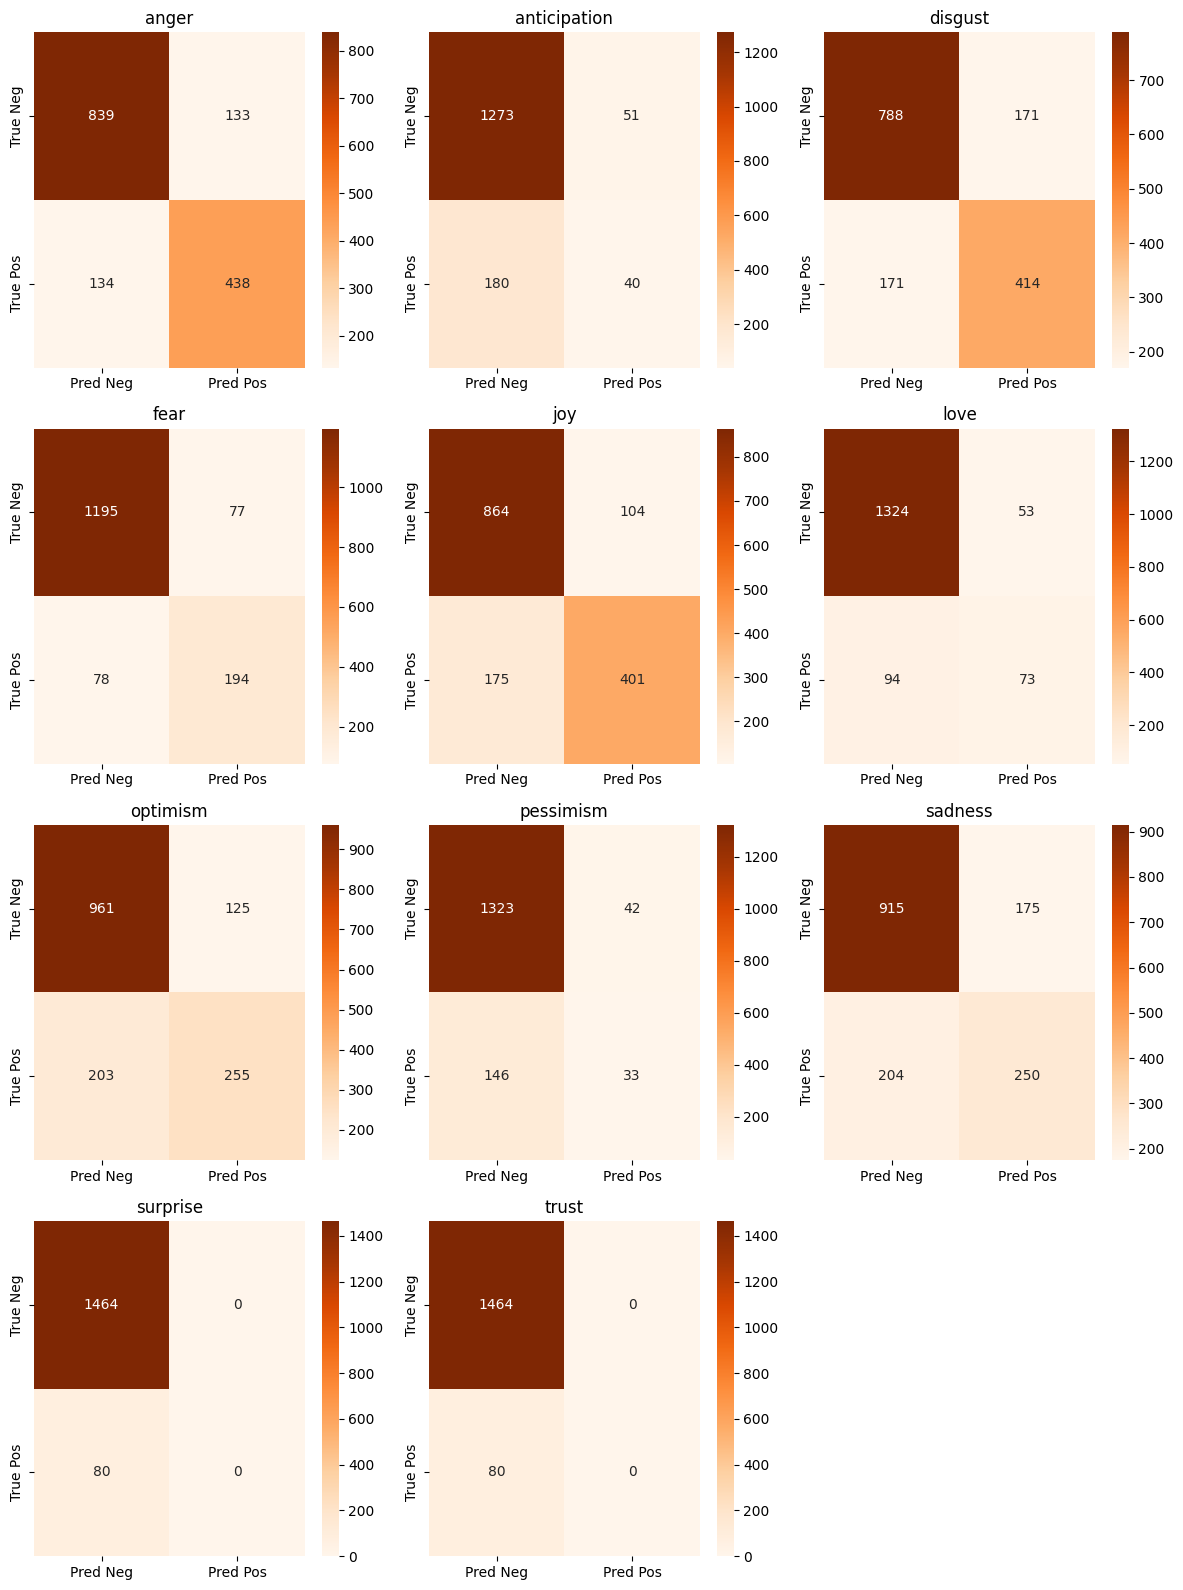

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


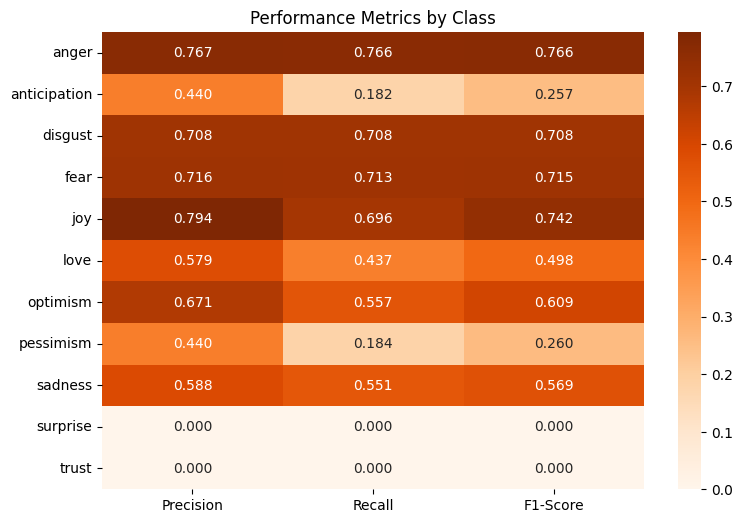

<Figure size 1200x533.333 with 0 Axes>

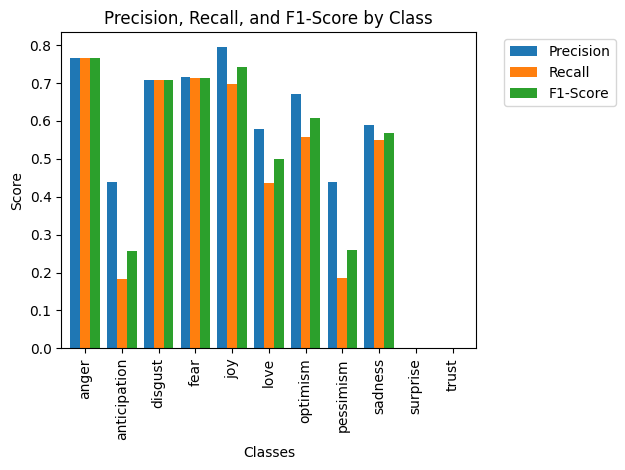

{'macro_avg': {'precision': 0.5184461475824056,
  'recall': 0.4357793861112636,
  'f1': 0.46575834673542055},
 'per_class': {'Precision': {'anger': 0.7670753064798599,
   'anticipation': 0.43956043956043955,
   'disgust': 0.7076923076923077,
   'fear': 0.7158671586715867,
   'joy': 0.7940594059405941,
   'love': 0.5793650793650794,
   'optimism': 0.6710526315789473,
   'pessimism': 0.44,
   'sadness': 0.5882352941176471,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.7657342657342657,
   'anticipation': 0.18181818181818182,
   'disgust': 0.7076923076923077,
   'fear': 0.7132352941176471,
   'joy': 0.6961805555555556,
   'love': 0.437125748502994,
   'optimism': 0.5567685589519651,
   'pessimism': 0.18435754189944134,
   'sadness': 0.5506607929515418,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.7664041994750657,
   'anticipation': 0.2572347266881029,
   'disgust': 0.7076923076923077,
   'fear': 0.714548802946593,
   'joy': 0.7419056429232193,
   'love'

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 2250.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task = 'text-classification',
    model = checkpoint,
    tokenizer = checkpoint,
    device = 0,
    return_all_scores = True
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Loading in the testing data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
# View Test
test_df = pd.DataFrame(test_ds).T
test_df.rename(columns ={0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print('-'*30)
print(test_df.shape)
print('There are no Labels for the entire test set')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no Labels for the entire test set


In [ ]:
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.9926220178604126},
  {'label': 'anticipation', 'score': 0.016125766560435295},
  {'label': 'disgust', 'score': 0.9744542837142944},
  {'label': 'fear', 'score': 0.33480513095855713},
  {'label': 'joy', 'score': 0.006114624440670013},
  {'label': 'love', 'score': 0.0004446545208338648},
  {'label': 'optimism', 'score': 0.007392688654363155},
  {'label': 'pessimism', 'score': 0.03296826779842377},
  {'label': 'sadness', 'score': 0.1841917484998703},
  {'label': 'surprise', 'score': 0.014909017831087112},
  {'label': 'trust', 'score': 0.000658368575386703}]]

In [ ]:
def get_labels(pipeline_output, threshold = 0.4):

  positive_labels = []

  for pred_set in pipeline_output:

    # getting the labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>=threshold]

    positive_labels.append(sample_positives)

  return positive_labels


In [ ]:
results = get_labels(preds, threshold = 0.4)
results

[['anger', 'disgust']]

# <font color = 'coral'>**Final Inferencing**

- In this step I will be doing inferencing on the test set with no labels and making a submission to the Kaggle Competition.
- Based on my observations so far, this should be the best model of the competition.
- I will be using my premade function to attach the labels and make a new csv.
- At the end of this notebook I will be writing a Final Report of the model.

In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, threshold = 0.4):
  """
  This function will process the pipeline output, apply the threshold and get predictions for the test dataset
  and generate a final DataFrame containing the test ID's and predicted labels.

  Parameters:
  - pipeline_output: The output from the custom pipeline (containing the scores)
  - model: The model used for generating the pipeline output (to get the id2labels)
  - df_test_ids: A dataframe containing the test ID's
  - threshold: The prediction threshold for making a prediction (default is 0.4)

  Returns:
  - df_pred_final: A pandas dataframe with the test ID's and their corresponding label predictions in binary format
  - positive_labels_list: a list of positive labels for each instance to compare results.
  """

  # 1. Prepare lists for appending results
  positive_labels_list = []
  binary_predictions = []

  # 2. Process the lists to store the binary preditions and positive labels

  for pred_set in pipeline_output:
    # Getting the positive labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>= threshold]
    positive_labels_list.append(sample_positives)

    # Getting the binary predictions ( 1 if >= threshold, else 0)
    binary_preds = [1 if pred['score'] >= threshold else 0 for pred in pred_set]
    binary_predictions.append(binary_preds)

  # 3. Convert the binary predictions to a dataframe
  # Map the model config labels
  class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]

  df_predictions = pd.DataFrame(binary_predictions, columns = class_labels)

  df_pred_final = pd.concat([df_test_ids.reset_index(drop = True), df_predictions], axis = 1 )

  # Setting the index of the final df to be the ID column
  df_pred_final = df_pred_final.set_index('ID')


  return df_pred_final, positive_labels_list


<font color = 'coral'>***Test set id column values from other notebook***

In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'coral'>***Here I am prepping the test_df to make predictions***

In [ ]:
test_ds = test_df.drop(columns = {'label'})

In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][0:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
# Input for my function
pipeline_output = custom_pipeline(test_ds['text'][:])

In [ ]:
# Setting the model and tokenizer to use my best checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

<font color = 'coral'>***Making predictions and getting the csv***

In [ ]:
# Getting the final labels and the list of predictions
df_pred_final, positive_labels_list = get_predictions_from_pipeline(pipeline_output = pipeline_output,
                                                                    model = model,
                                                                    df_test_ids = test_ids,
                                                                    threshold = 0.4)

df_pred_final.sum()

,0
anger,1070
anticipation,308
disgust,1151
fear,549
joy,1359
love,442
optimism,1252
pessimism,316
sadness,1058
surprise,0


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_distilBERT.csv')